LeNet5 model 

In [29]:
import pandas as pd 
import numpy as np 



import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_cuda=True


In [30]:
# defining hyperparameters 
#epochs = 40   #the nn will train 40 times over all 50.000 images and validate itself with 12.000 images x 40 times) 
epochs =  500
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [31]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])

In [19]:
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669)),

AttributeError: 'Compose' object has no attribute 'Normalize'

In [7]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [8]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=transforms,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7faed7f4ee20>, <torch.utils.data.dataloader.DataLoader object at 0x7fae59cc8910>)


In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [7]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [8]:
# train function
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [9]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [23]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat  = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [24]:
# model function 
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [32]:

torch.manual_seed(random_seed)

model = LeNet5(classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [33]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)


12:04:54 --- Epoch: 0	Train loss: 3.3888	Valid loss: 2.9976	Train accuracy: 24.43	Valid accuracy: 25.19
12:05:01 --- Epoch: 1	Train loss: 2.5803	Valid loss: 2.2214	Train accuracy: 39.81	Valid accuracy: 39.94
12:05:09 --- Epoch: 2	Train loss: 1.9630	Valid loss: 1.7334	Train accuracy: 52.05	Valid accuracy: 51.76
12:05:17 --- Epoch: 3	Train loss: 1.5404	Valid loss: 1.3660	Train accuracy: 63.50	Valid accuracy: 63.38
12:05:24 --- Epoch: 4	Train loss: 1.2220	Valid loss: 1.0994	Train accuracy: 72.46	Valid accuracy: 71.64
12:05:32 --- Epoch: 5	Train loss: 0.9942	Valid loss: 0.9060	Train accuracy: 78.62	Valid accuracy: 77.85
12:05:40 --- Epoch: 6	Train loss: 0.8264	Valid loss: 0.7604	Train accuracy: 82.72	Valid accuracy: 82.47
12:05:47 --- Epoch: 7	Train loss: 0.6979	Valid loss: 0.6482	Train accuracy: 85.70	Valid accuracy: 85.87
12:05:55 --- Epoch: 8	Train loss: 0.5974	Valid loss: 0.5607	Train accuracy: 88.03	Valid accuracy: 87.69
12:06:03 --- Epoch: 9	Train loss: 0.5178	Valid loss: 0.4914	Trai

In [ ]:
# model 
# Conv NN constructors:
class ConvNN(nn.Module):
    name = ""

    def __init__(self, params):
        """
        The purpose in using this class in the way it built is to make the process of creating CNNs with the ability
        to control its capacity in efficient way (programming efficiency - not time efficiency).
        :param params: a dictionary with the following attributes:
            capacity influence:
            - channels_lst: lst of the channels sizes. the network complexity is inflected mostly by this parameter
              * for efficiency channels_lst[0] is the number of input channels
            - #FC_Layers: number of fully connected layers
            - extras_blocks_components: in case we want to add layers from the list ["dropout", "max_pool", "batch norm"]
                                        to each block we can do it. Their parameters are attributes of this dict also.
              * notice that if max_pool in extras_blocks_components then we reduce dims using max_pool instead conv
                layer (the conv layer will be with stride 1 and padding)
            - p_dropout: the dropout parameter

            net structure:
            - in_wh: input width and height
        """
        super().__init__()
        self.params = params
        channels_lst = params["channels_lst"]
        extras_block_components = params["extras_blocks_components"]

        assert 2 <= len(channels_lst) <= 5
        conv_layers = []
        for i in range(1, len(channels_lst)):
            """
            Dims calculations: next #channels x (nh-filter_size/2)+1 x (nw-filter_size/2)+1
            """
            filter_size, stride, padding = (4, 2, 1) if "max_pool" not in extras_block_components else (5, 1, 2)
            conv_layers.append(nn.Conv2d(channels_lst[i - 1], channels_lst[i], filter_size, stride, padding, bias=False))
            conv_layers.append(params["activation"]())

            for comp in extras_block_components:
                if comp == "dropout":
                    conv_layers.append(nn.Dropout(params["p_dropout"]))
                if comp == "max_pool":
                    conv_layers.append(nn.MaxPool2d(2, 2))
                if comp == "batch_norm":
                    conv_layers.append(nn.BatchNorm2d(channels_lst[i]))

        out_channels = channels_lst[-1]
        if params["CNN_out_channels"] is not None:
            conv_layers.append(nn.Conv2d(channels_lst[-1], params["CNN_out_channels"], 1))
            conv_layers.append(params["activation"]())
            out_channels = params["CNN_out_channels"]

        self.cnn = nn.Sequential(*conv_layers)

        lin_layers = []
        wh = params["in_wh"] // (2 ** (len(channels_lst) - 1))  # width and height of last layer output
        lin_layer_width = out_channels * (wh ** 2)
        for _ in range(params["#FC_Layers"] - 1):
            lin_layers.append(nn.Linear(lin_layer_width, lin_layer_width))
        lin_layers.append(nn.Linear(lin_layer_width, params["out_size"]))
        self.linear_nn = nn.Sequential(*lin_layers)

        """ we use CE loss so we don't need to apply softmax (for test loss we also use the same CE. for accuracy
            we choose the highest value - this property is saved under softmax)"""

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.view(1, *x.shape)
        assert x.shape[2] == x.shape[3] == self.params["in_wh"]
        assert x.shape[1] == self.params["channels_lst"][0]

        cnn_output = self.cnn(x).view((x.shape[0], -1))
        lin_output = self.linear_nn(cnn_output)
        return lin_output


def create_conv_nn(params):
    return ConvNN(params)


class LeNet5TrafficSign(nn.Module):
    name = "Lenet5-TrafficSign"
    def __init__(self, in_channels=3, out_channels=43):
        super().__init__()
        self.cnn = nn.Sequential(            
            nn.Conv2d(in_channels, 6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.lin = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 43)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.lin(x)
        return x




In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 43]           3,655
Total params: 64,811
Trainable params: 64,811
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=43, bias=True)
  )
)

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

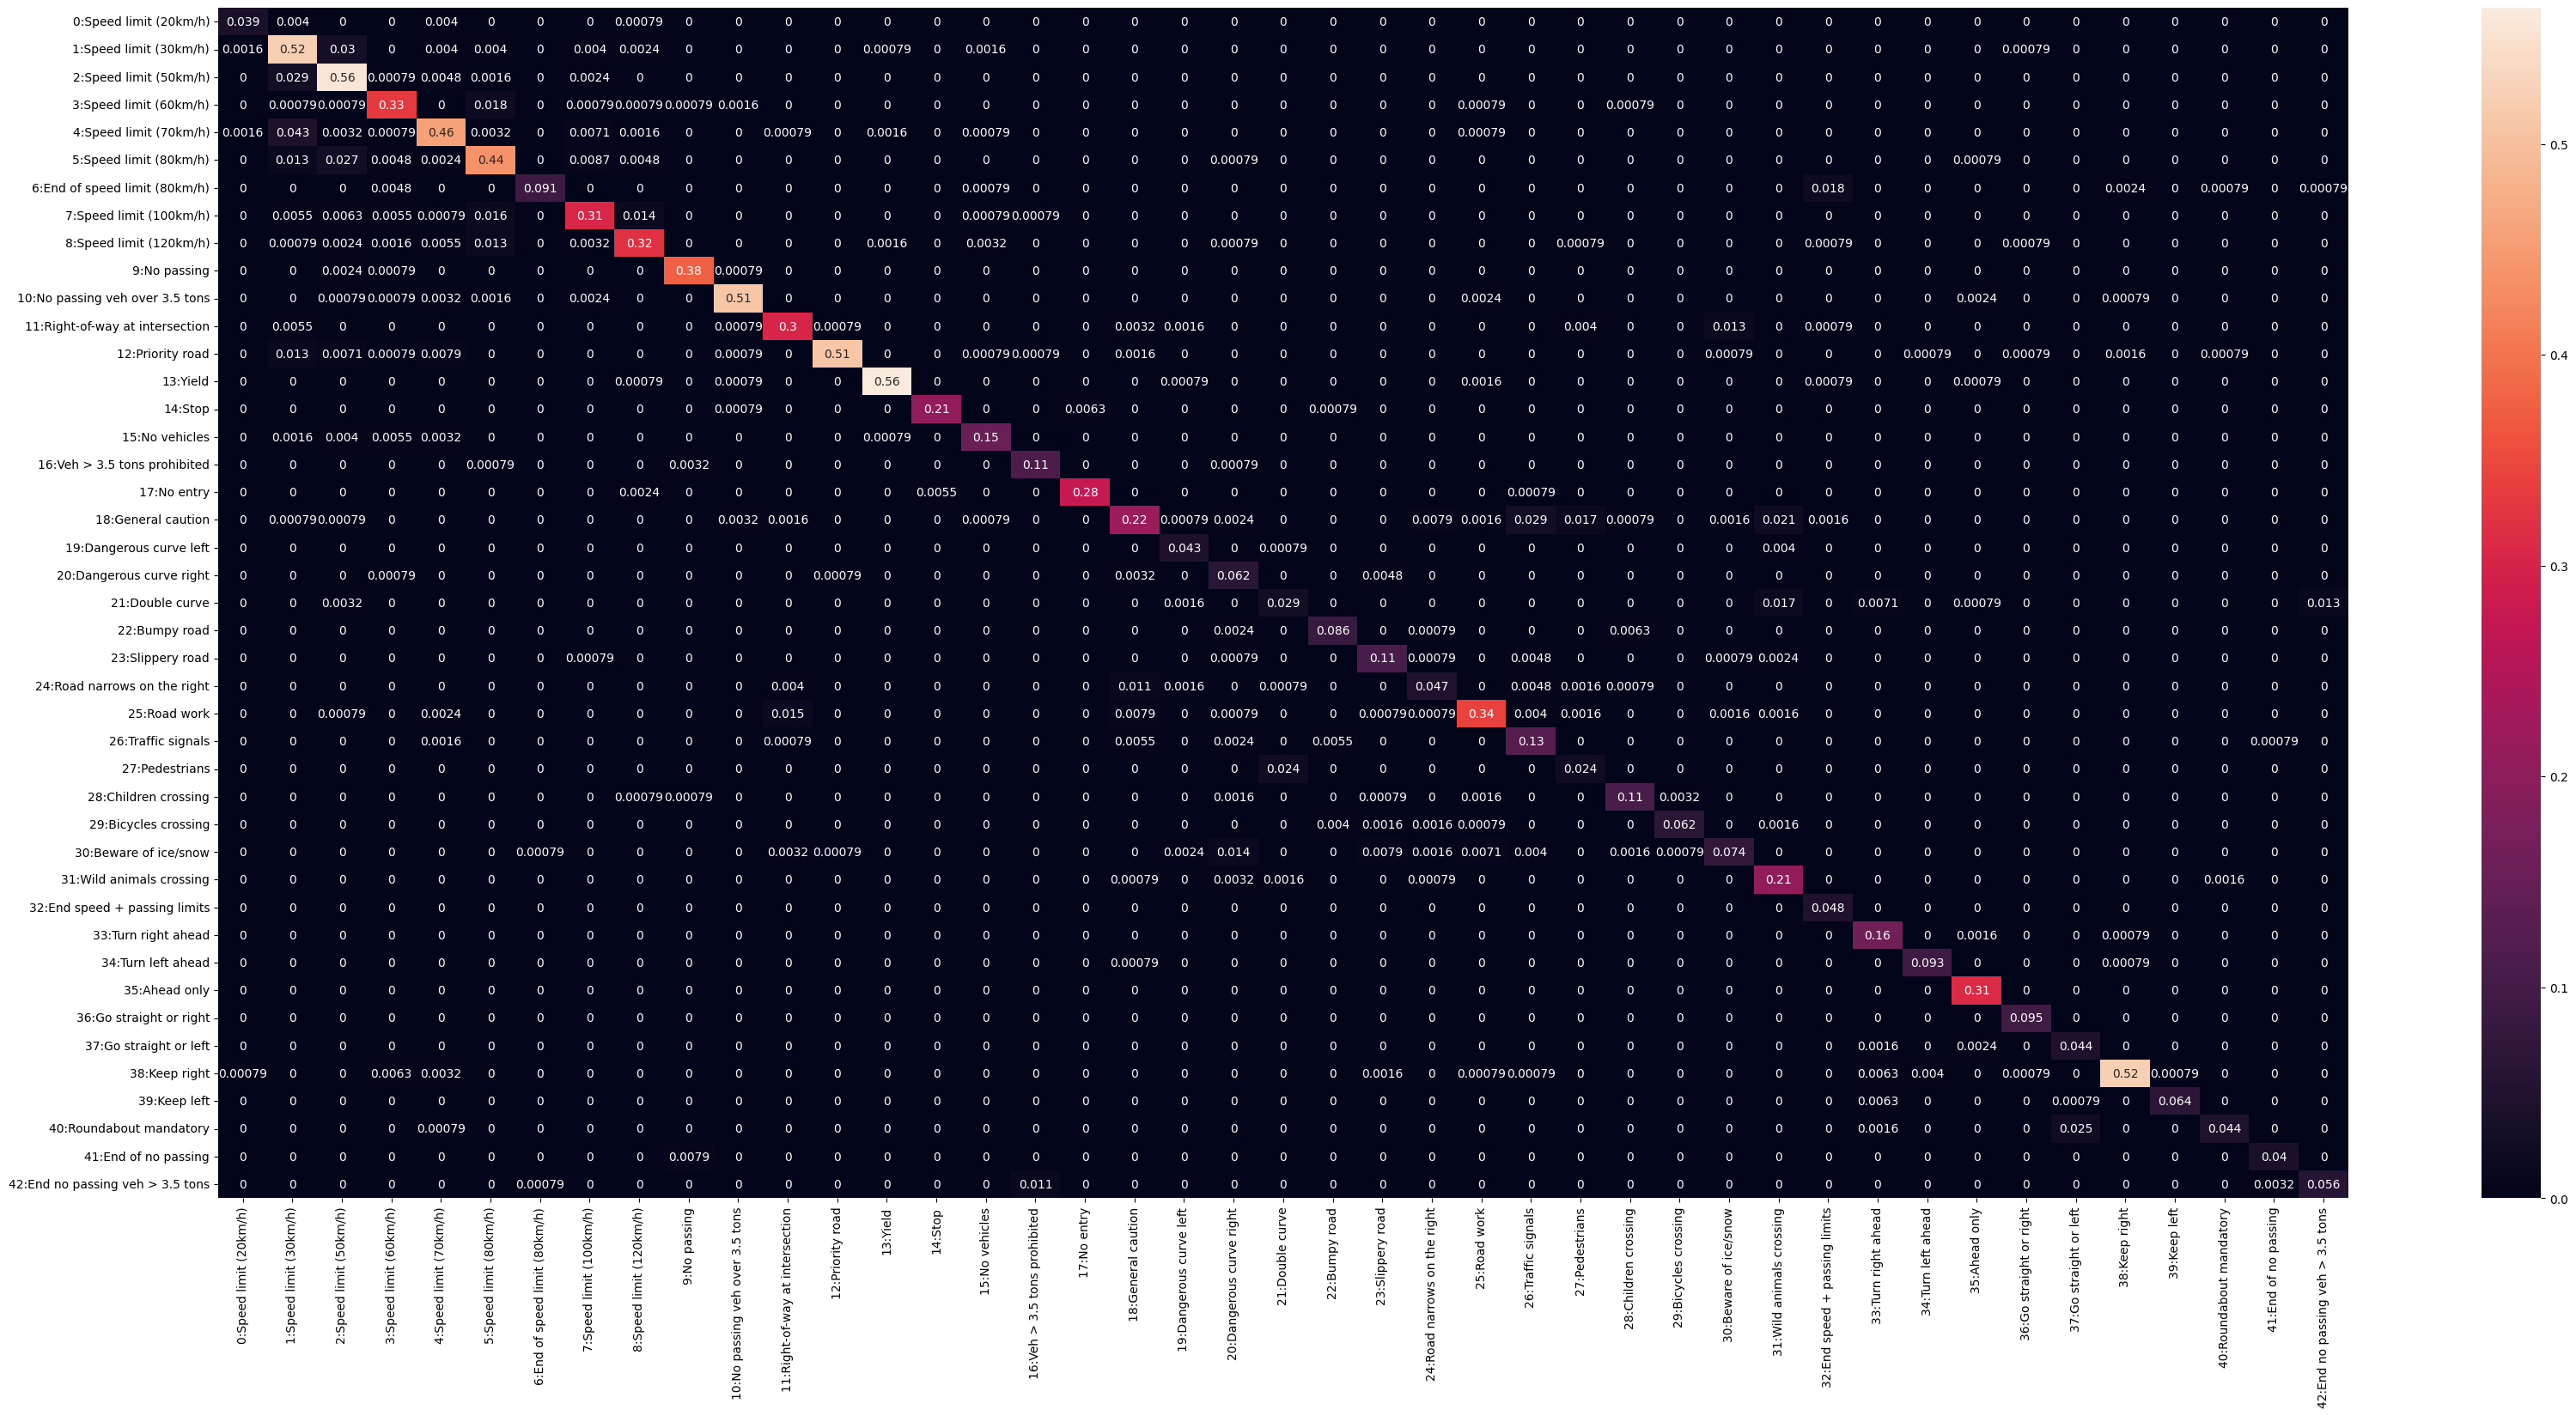

In [ ]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,18))
sn.heatmap(df_cm, annot=True)
plt.savefig('Lenet5.png')

In [ ]:
cf_report = classification_report(y_true, y_pred, zero_division = 0)
print(cf_report)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        60
           1       0.82      0.91      0.86       720
           2       0.86      0.94      0.90       750
           3       0.91      0.93      0.92       450
           4       0.91      0.88      0.89       660
           5       0.88      0.88      0.88       630
           6       0.98      0.77      0.86       150
           7       0.91      0.86      0.89       450
           8       0.92      0.90      0.91       450
           9       0.97      0.99      0.98       480
          10       0.98      0.97      0.98       660
          11       0.92      0.91      0.92       420
          12       1.00      0.93      0.96       690
          13       0.99      0.99      0.99       720
          14       0.97      0.96      0.97       270
          15       0.95      0.91      0.93       210
          16       0.90      0.96      0.93       150
          17       0.98    

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, zero_division = 0, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons']))



Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.87
Macro Recall: 0.87
Macro F1-score: 0.87

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.91

Classification Report

                                  precision    recall  f1-score   support

          0:Speed limit (20km/h)       0.91      0.82      0.86        60
          1:Speed limit (30km/h)       0.82      0.91      0.86       720
          2:Speed limit (50km/h)       0.86      0.94      0.90       750
          3:Speed limit (60km/h)       0.91      0.93      0.92       450
          4:Speed limit (70km/h)       0.91      0.88      0.89       660
          5:Speed limit (80km/h)       0.88      0.88      0.88       630
   6:End of speed limit (80km/h)       0.98      0.77      0.86       150
         7:Speed limit (100km/h)       0.91      0.86      0.89       450
         8:Speed limit (120km/h)       0.92      0.90      0.91       450
                    9